# Chapter 3: Static portfolio optimization


### 3.1 Explanation behind portfolio optimization method
> ###### 3.1.1 Systemic risk and specific risk
> ###### 3.1.2 Diversification

### 3.2 The traditional portfolio optimization methods
> ###### 3.2.1 Portfolio utility function
> ###### 3.2.2 Mean variance criterion
> ###### 3.3.3 Mean variance skewness kurtosis criterion

### 3.3 The modern portoflio optimization methods
> ###### 3.3.1 Sharpe criterion
> ###### 3.3.2 Sortino criterion


In [1]:
from scipy.optimize import minimize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import warnings
warnings.filterwarnings("ignore")
import yfinance as yf

<ipython-input-1-6fa51f2907a6>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [18]:
def backtest_static_portfolio(weights, database, ben="^GSPC", timeframe=252, CR=False):
    """
    -----------------------------------------------------------------------------
    | Output: Backtest static portfolio                                         |
    -----------------------------------------------------------------------------
    | Inputs: - weights (type 1d array numpy): weights of the portfolio         |
    |         - database (type dataframe pandas): Returns of the asset          |
    |         - ben (type string): Name of the benchmark                        |
    |         - timeframe (type int): annualization factor                      |
    -----------------------------------------------------------------------------
    """
    import pandas as pd
    import yfinance as yf
    import numpy as np
    from scipy.optimize import minimize
    import matplotlib.pyplot as plt
    plt.style.use('seaborn')


    # Compute the portfolio
    portfolio = np.multiply(database,np.transpose(weights))
    portfolio = portfolio.sum(axis=1)
    columns = database.columns
    columns = [col for col in columns]

    ######################### COMPUTE THE BETA ##################################
    # Import the benchmark
    benchmark = yf.download(ben)["Adj Close"].pct_change(1).dropna()

    # Concat the asset and the benchmark
    join = pd.concat((portfolio, benchmark), axis=1).dropna()

    # Covariance between the asset and the benchmark
    cov = np.cov(join, rowvar=False)[0][1]

    # Compute the variance of the benchmark
    var = np.cov(join, rowvar=False)[1][1]

    beta = cov/var


    ######################### COMPUTE THE ALPHA #################################
    # Mean of returns for the asset
    mean_stock_return = join.iloc[:,0].mean()*timeframe

    # Mean of returns for the market
    mean_market_return = join.iloc[:,1].mean()*timeframe

    # Alpha
    alpha = mean_stock_return - beta*mean_market_return


    ######################### COMPUTE THE SHARPE ################################
    mean = portfolio.mean() * timeframe
    std = portfolio.std() * np.sqrt(timeframe)
    Sharpe = mean/std


    ######################### COMPUTE THE SORTINO ###############################
    downward = portfolio[portfolio<0]
    std_downward = downward.std() * np.sqrt(timeframe)
    Sortino = mean/std_downward


    ######################### COMPUTE THE DRAWDOWN ###############################
    # Compute the cumulative product returns
    cum_rets = (portfolio+1).cumprod()

    # Compute the running max
    running_max = np.maximum.accumulate(cum_rets.dropna())
    running_max[running_max < 1] = 1

    # Compute the drawdown
    drawdown = ((cum_rets)/running_max - 1)
    min_drawdon = -drawdown.min()


    ######################### COMPUTE THE VaR ##################################
    theta = 0.01
    # Number of simulations
    n = 100000

    # Find the values for theta% error threshold
    t = int(n*theta)

    # Create a vector with n simulations of the normal law
    vec = pd.DataFrame(np.random.normal(mean, std, size=(n,)),
                      columns = ["Simulations"])

    # Orderer the values and find the theta% value
    VaR = -vec.sort_values(by="Simulations").iloc[t].values[0]


    ######################### COMPUTE THE cVaR #################################
    cVaR = -vec.sort_values(by="Simulations").iloc[0:t,:].mean().values[0]

    ######################### COMPUTE THE RC ###################################
    if CR:
    # Find the number of the asset in the portfolio
        l = len(weights)

        # Compute the risk contribution of each asset
        crs = []
        for i in range(l):
            # Importation of benchmark
            benchmark = yf.download(ben)["Adj Close"].pct_change(1).dropna()

            # Concat the asset and the benchmark
            join_bis = pd.concat((database.iloc[:,i], benchmark), axis=1).dropna()

            # Covariance between the asset and the benchmark
            cov = np.cov(join_bis, rowvar=False)[0][1]

            # Compute the variance of the benchmark
            var = np.cov(join_bis, rowvar=False)[1][1]

            beta_s = cov/var
            cr = beta_s * weights[i]
            crs.append(cr)

        crs = crs/np.sum(crs) # Normalizing by the sum of the risk contribution

    ######################### PLOT THE RESULTS #################################
    print(f"""
    -----------------------------------------------------------------------------
    Portfolio: {columns}
    -----------------------------------------------------------------------------
    Beta: {np.round(beta, 3)} \t Alpha: {np.round(alpha*100, 2)} %\t \
    Sharpe: {np.round(Sharpe, 3)} \t Sortino: {np.round(Sortino, 3)}
    -----------------------------------------------------------------------------
    VaR: {np.round(VaR*100, 2)} %\t cVaR: {np.round(cVaR*100, 2)} % \t \
    VaR/cVaR: {np.round(cVaR/VaR, 3)} \t drawdown: {np.round(min_drawdon*100, 2)} %
    -----------------------------------------------------------------------------
    """)


    plt.figure(figsize=(15,8))
    plt.plot(join.iloc[:,0].cumsum()*100, color="#035593", linewidth=3)
    plt.plot(join.iloc[:,1].cumsum()*100, color="#068C72", linewidth=3)
    plt.title("CUMULTATIVE RETURN", size=15)
    plt.ylabel("Cumulative return %", size=15)
    plt.xticks(size=15,fontweight="bold")
    plt.yticks(size=15,fontweight="bold")
    plt.legend(["Strategy", "Benchmark"])
    plt.show()

    plt.figure(figsize=(15,8))
    plt.fill_between(drawdown.index, drawdown*100, 0, color="#CE5151")
    plt.plot(drawdown.index,drawdown*100, color="#930303", linewidth=1.5)
    plt.title("DRAWDOWN", size=15)
    plt.ylabel("Drawdown %", size=15)
    plt.xticks(size=15,fontweight="bold")
    plt.yticks(size=15,fontweight="bold")
    plt.show()



    if CR:
        plt.figure(figsize=(15,8))
        plt.scatter(columns, crs, linewidth=3, color = "#B96553")
        plt.axhline(0, color="#53A7B9")
        plt.grid(axis="x")
        plt.title("RISK CONTRIBUTION PORTFOLIO", size=15)
        plt.xlabel("Assets")
        plt.ylabel("Risk contribution")
        plt.xticks(size=15,fontweight="bold")
        plt.yticks(size=15,fontweight="bold")
        plt.show()
        plt.show()

In [30]:
# Importation of data
list_tickers = ["META", "NFLX", "TSLA"]
database = yf.download(list_tickers)

# Take only the adjusted stock price
database = database["Adj Close"]

# Drop missing values
data = database.dropna().pct_change(1).dropna()

[*********************100%%**********************]  3 of 3 completed


In [31]:
data.shape

(2926, 3)

In [32]:
data.head()

,META,NFLX,TSLA
Date,,,
2012-05-21,-0.109861,0.025443,0.043904
2012-05-22,-0.089039,-0.056175,0.070559
2012-05-23,0.032258,0.062029,0.007143
2012-05-24,0.032187,-0.022806,-0.023855
2012-05-25,-0.033909,-0.000711,-0.015522


<br>
<br>
<br>



    
# 3.2.2 Mean variance optimization


In [53]:
def MV_criterion(weights, data):
    """
    -----------------------------------------------------------------------------
    | Output: optimization porfolio criterion                                   |
    -----------------------------------------------------------------------------
    | Inputs: -weight (type ndarray numpy): Wheight for portfolio               |
    |         -data (type ndarray numpy): Returns of stocks                     |
    -----------------------------------------------------------------------------
    """

    # Parameters
    Lambda = 3
    W = 1
    Wbar = 1 + 0.25 / 100

    # Compute portfolio returns
    portfolio_return = np.multiply(data, np.transpose(weights))
    portfolio_return = portfolio_return.sum(axis=1)

    # Compute mean and volatility of the portfolio
    mean = np.mean(portfolio_return, axis=0)
    std = np.std(portfolio_return, axis=0)
    print('std: ', std)
    # Compute the criterion
    criterion = Wbar ** (1 - Lambda) / (1 + Lambda) + Wbar ** (-Lambda) \
                * W * mean - Lambda / 2 * Wbar ** (-1 - Lambda) * W ** 2 * std ** 2
    criterion = -criterion

    return criterion

In [54]:
# Define train and test sets
split = int(0.7 * len(data))
train_set = data.iloc[:split, :]
test_set = data.iloc[split:, :]

# Find the number of asset
n = data.shape[1]

# Initialisation weight value
x0 = np.ones(n)

# Optimization constraints problem
cons = ({'type': 'eq', 'fun': lambda x: sum(abs(x)) - 1})

# Set the bounds
Bounds = [(0, 1) for i in range(0, n)]

# Optimization problem solving
res_MV = minimize(MV_criterion, x0, method="SLSQP",
                  args=(train_set), bounds=Bounds,
                  constraints=cons, options={'disp': True})

# Result for computations
X_MV = res_MV.x

std:  0.06315749393656833
std:  0.06315749371203178
std:  0.06315749360742075
std:  0.06315749354913246
std:  0.02104892442189191
std:  0.0210489246465321
std:  0.021048924751153157
std:  0.02104892480911026
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.25012313691060106
            Iterations: 2
            Function evaluations: 8
            Gradient evaluations: 2


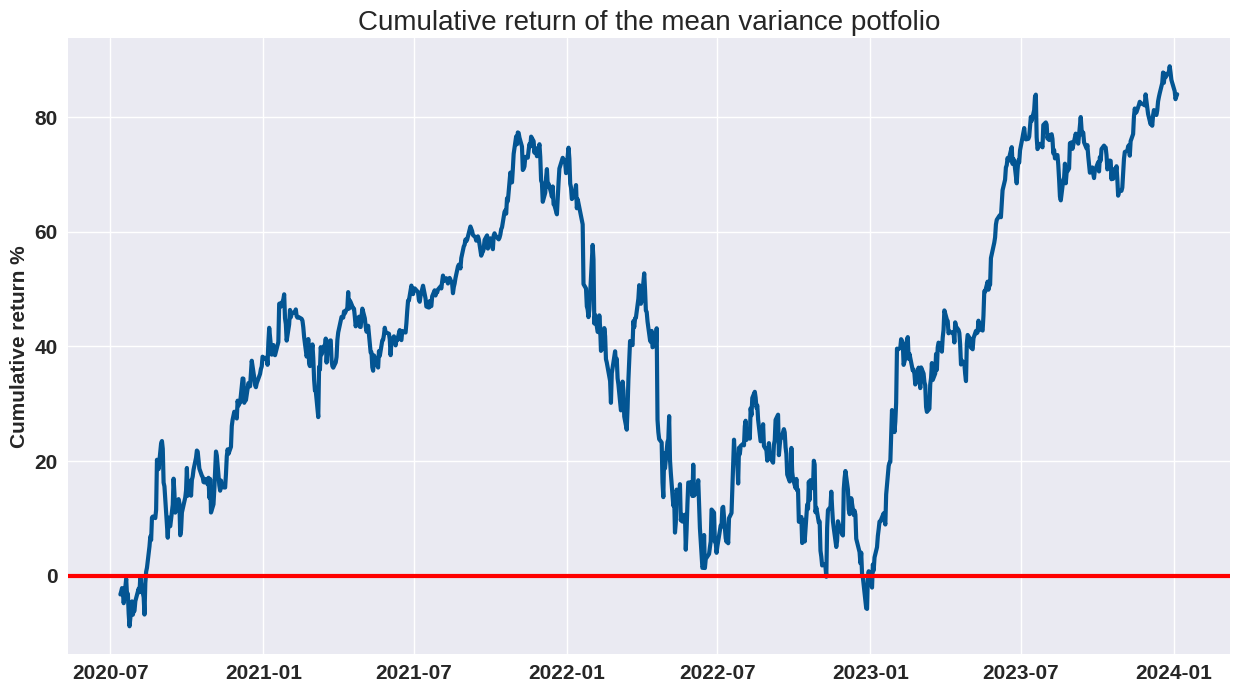

In [37]:
# Compute the cumulative return of the portfolio (CM)
portfolio_return_MV = np.multiply(test_set,np.transpose(X_MV))
portfolio_return_MV = portfolio_return_MV.sum(axis=1)

# Plot the CM
plt.figure(figsize=(15,8))
plt.plot(np.cumsum(portfolio_return_MV)*100, color="#035593", linewidth=3)
plt.ylabel("Cumulative return %", size=15, fontweight="bold")
plt.xticks(size=15,fontweight="bold")
plt.yticks(size=15,fontweight="bold")
plt.title("Cumulative return of the mean variance potfolio", size=20)
plt.axhline(0, color="r",linewidth=3)
plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Portfolio: ['META', 'NFLX', 'TSLA']
    -----------------------------------------------------------------------------
    Beta: 1.655 	 Alpha: 3.13 %	     Sharpe: 0.596 	 Sortino: 0.822
    -----------------------------------------------------------------------------
    VaR: 69.83 %	 cVaR: 83.2 % 	     VaR/cVaR: 1.191 	 drawdown: 62.74 %
    -----------------------------------------------------------------------------
    


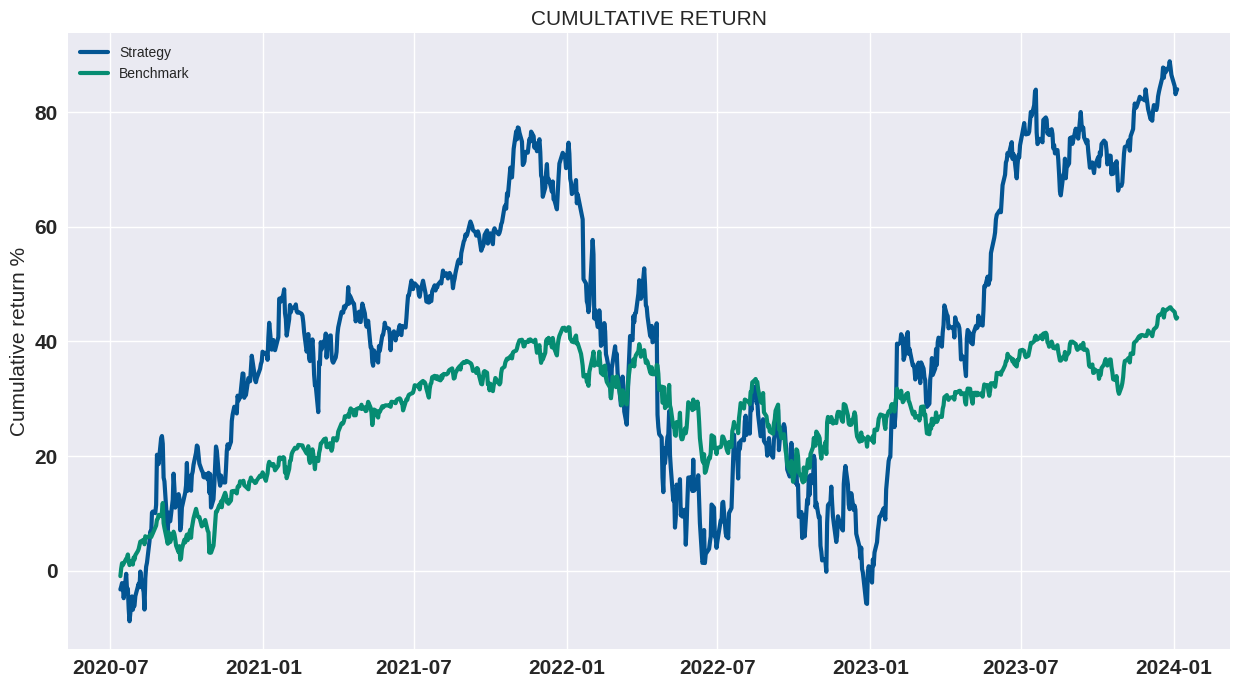

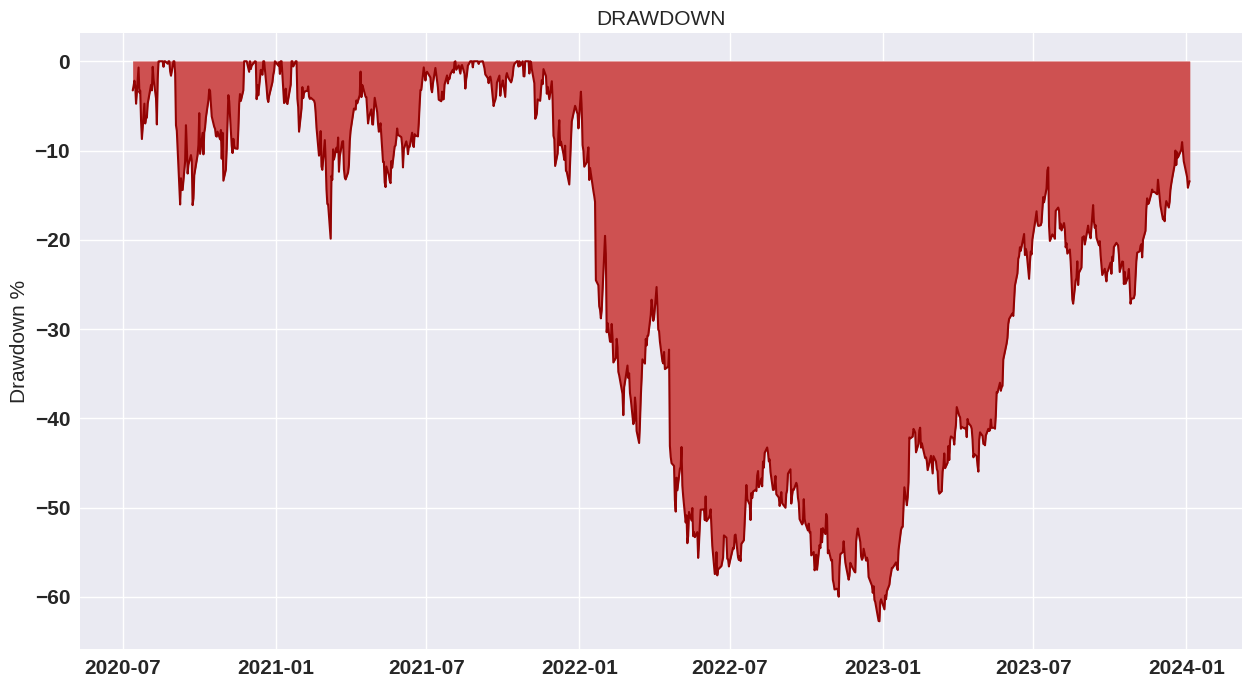

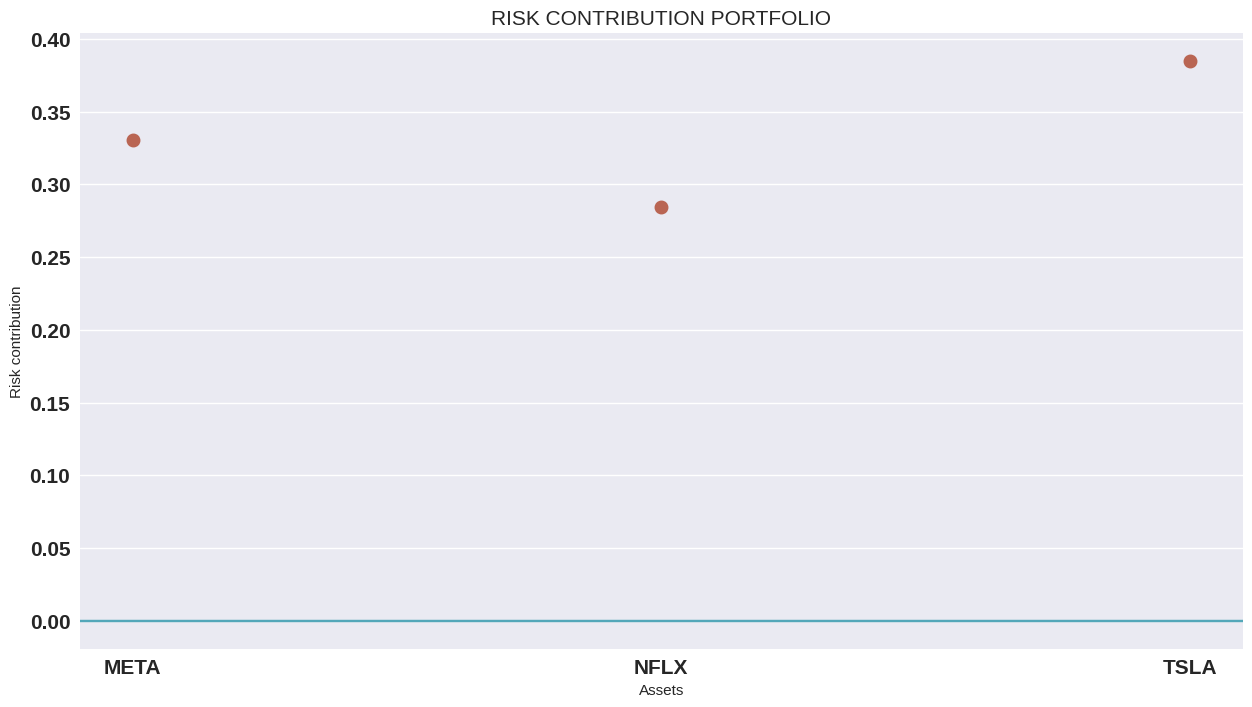

In [38]:
# Code from chapter 5
#from Backtest import *
backtest_static_portfolio(X_MV, test_set, CR=True)

<br>
<br>
<br>



# 3.2.3 Mean variance skewness kurtosis

In [39]:
def SK_criterion(weights, data):
    """
    -----------------------------------------------------------------------------
    | Output: optimization porfolio criterion                                   |
    -----------------------------------------------------------------------------
    | Inputs: -weight (type ndarray numpy): Wheight for portfolio               |
    |         -data (type ndarray numpy): Returns of stocks                     |
    -----------------------------------------------------------------------------
    """
    from scipy.stats import skew, kurtosis
    # Parameters
    Lambda = 3
    W = 1
    Wbar = 1 + 0.25 / 100

    # Compute portfolio returns
    portfolio_return = np.multiply(data, np.transpose(weights))
    portfolio_return = portfolio_return.sum(axis=1)

    # Compute mean, volatility, skew, kurtosis of the portfolio
    mean = np.mean(portfolio_return, axis=0)
    std = np.std(portfolio_return, axis=0)
    skewness = skew(portfolio_return, 0)
    kurt = kurtosis(portfolio_return, 0)

    # Compute the criterion
    criterion = Wbar ** (1 - Lambda) / (1 + Lambda) + Wbar ** (-Lambda) \
    * W * mean - Lambda / 2 * Wbar ** (-1 - Lambda) * W ** 2 * std ** 2 \
    + Lambda * (Lambda + 1) / (6) * Wbar ** (-2 - Lambda) * W ** 3 * skewness \
    - Lambda * (Lambda + 1) * (Lambda + 2) / (24) * Wbar ** (-3 - Lambda) *\
     W ** 4 * kurt

    criterion = -criterion

    return criterion

In [40]:
# Find the number of asset
n = data.shape[1]

# Initialization weight value
x0 = np.ones(n)

# Optimization constraints problem
cons = ({'type': 'eq', 'fun': lambda x: sum(abs(x)) - 1})

# Set the bounds
Bounds = [(0, 1) for i in range(0, n)]

# Optimization problem solving
res_SK = minimize(SK_criterion, x0, method="SLSQP",
                  args=(train_set), bounds=Bounds,
                  constraints=cons, options={'disp': True})

# Result
X_SK = res_SK.x

Optimization terminated successfully    (Exit mode 0)
            Current function value: 9.903224282212602
            Iterations: 9
            Function evaluations: 40
            Gradient evaluations: 9


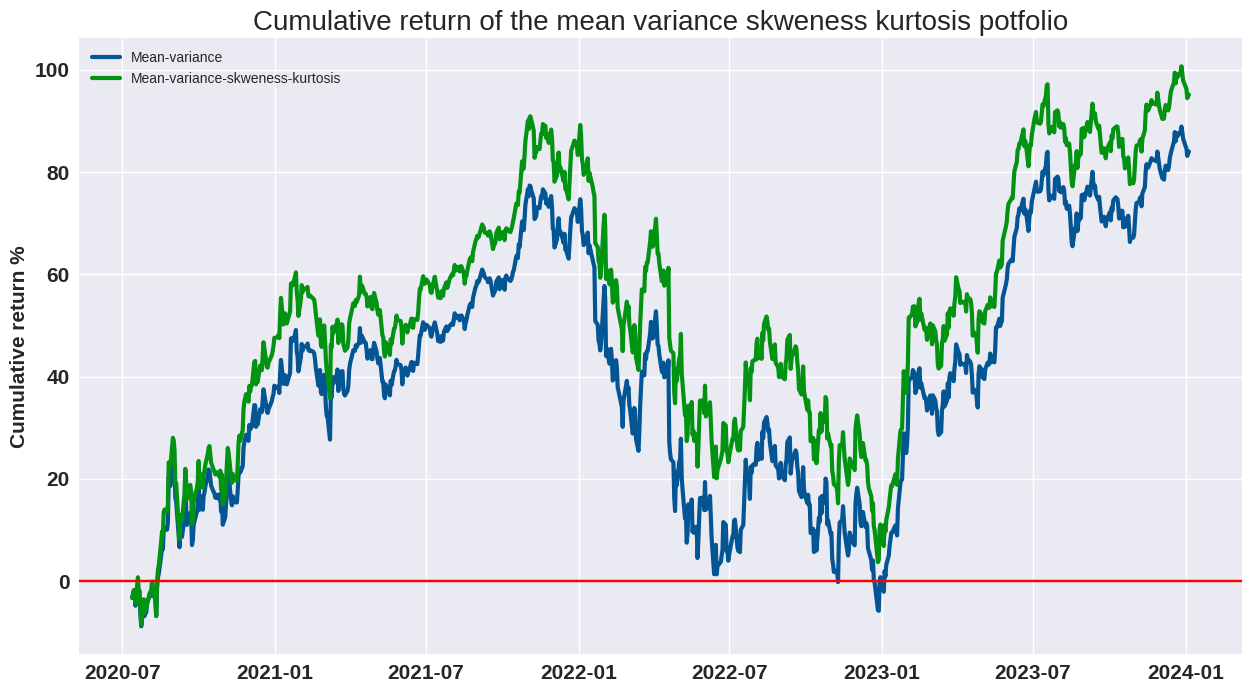

In [41]:
# Compute the cumulative return of the portfolio (CM)
portfolio_return_SK = np.multiply(test_set,np.transpose(X_SK))
portfolio_return_SK = portfolio_return_SK.sum(axis=1)

# Plot the CM
fig = plt.figure(figsize=(15,8))
plt.plot(np.cumsum(portfolio_return_MV)*100, color="#035593", linewidth=3)
plt.plot(np.cumsum(portfolio_return_SK)*100, color="#039313", linewidth=3)
plt.ylabel("Cumulative return %", size=15, fontweight="bold")
plt.axhline(0, color="r")
plt.legend(["Mean-variance", "Mean-variance-skweness-kurtosis"])
plt.title("Cumulative return of the mean variance skweness kurtosis potfolio", size=20)
plt.xticks(size=15, fontweight="bold")
plt.yticks(size=15, fontweight="bold")
plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Portfolio: ['META', 'NFLX', 'TSLA']
    -----------------------------------------------------------------------------
    Beta: 1.7 	 Alpha: 5.75 %	     Sharpe: 0.648 	 Sortino: 0.922
    -----------------------------------------------------------------------------
    VaR: 70.36 %	 cVaR: 84.81 % 	     VaR/cVaR: 1.205 	 drawdown: 64.22 %
    -----------------------------------------------------------------------------
    


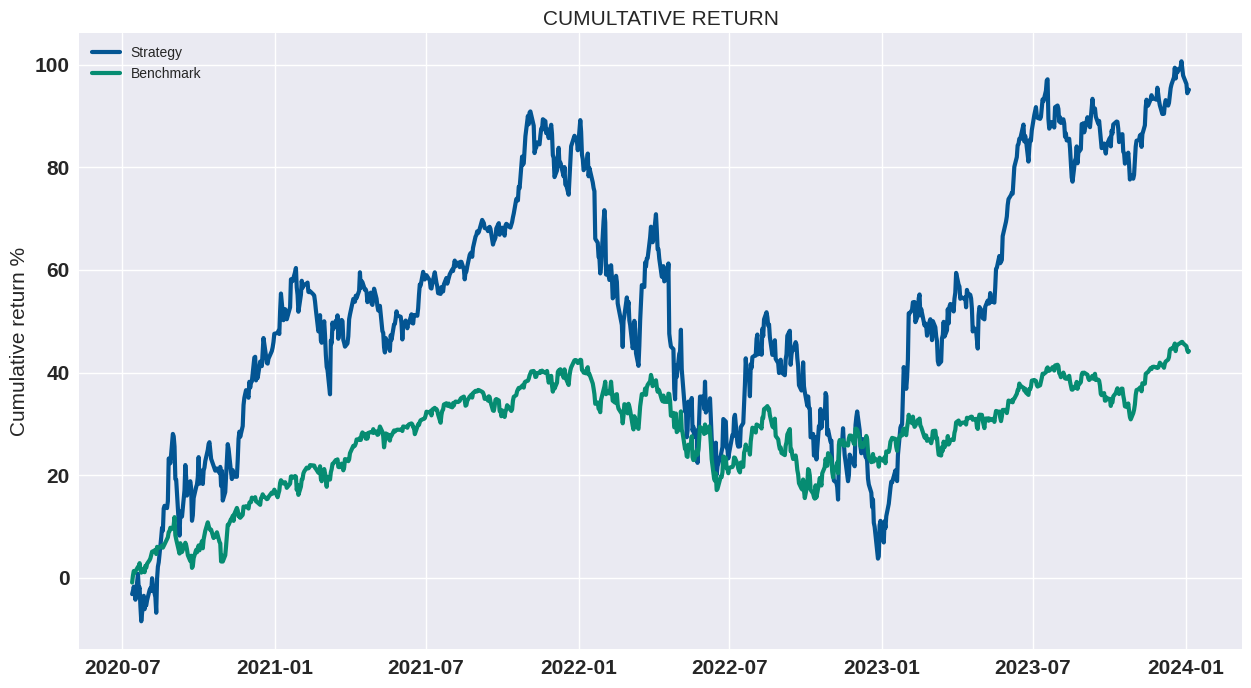

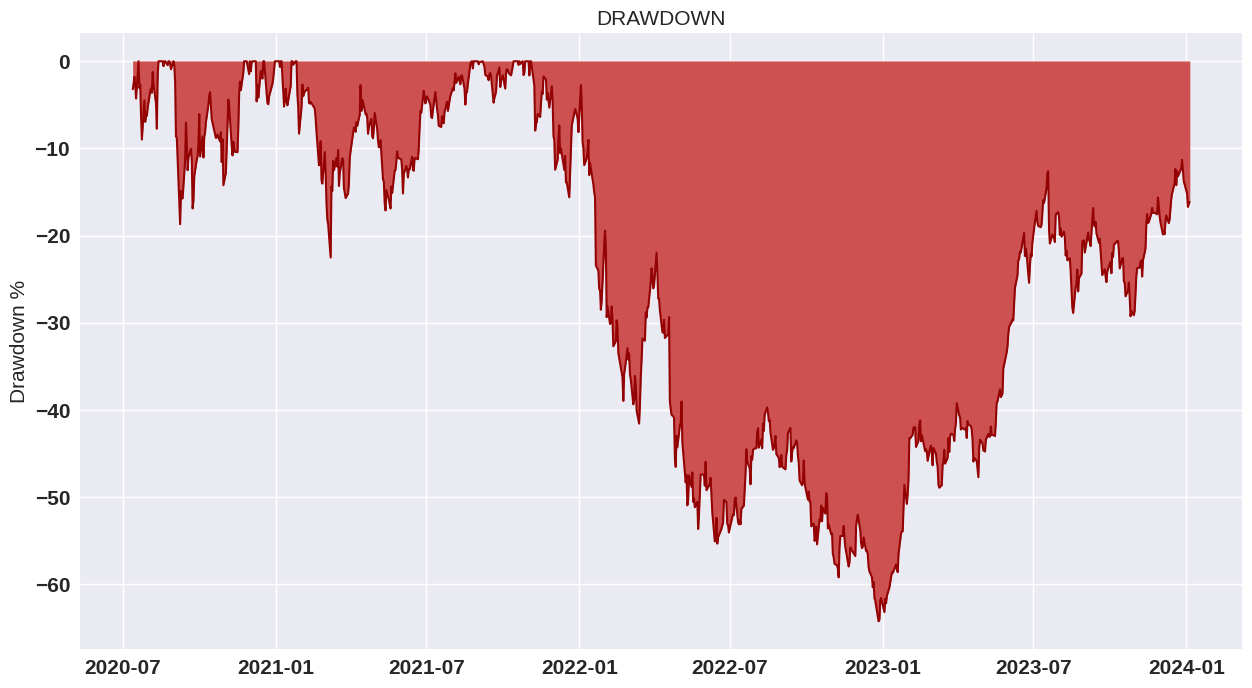

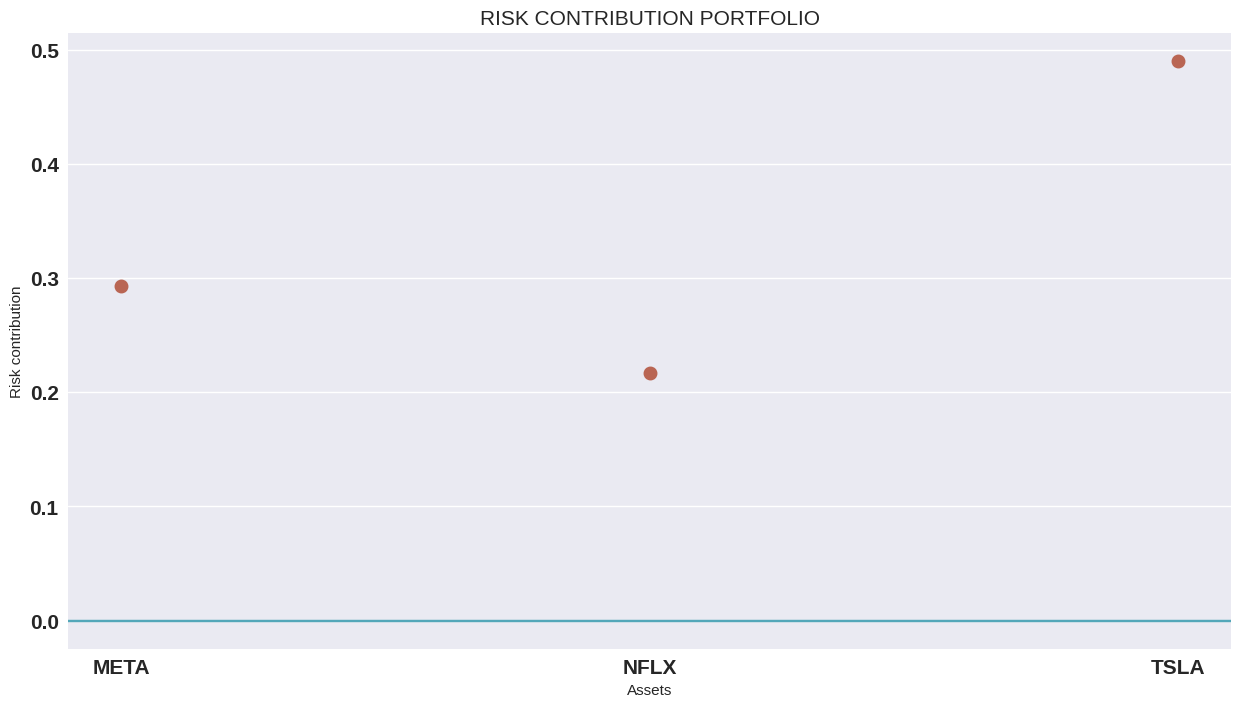

In [42]:
backtest_static_portfolio(X_SK, test_set, CR=True)

<br>
<br>
<br>



# 3.3.1 Sharpe ratio criterion

In [11]:
def SR_criterion(weight, data):
    """
    -----------------------------------------------------------------------------
    | Output: Opposite Sortino ratio to do a mimization                         |
    -----------------------------------------------------------------------------
    | Inputs: -Weight (type ndarray numpy): Wheight for portfolio               |
    |         -data (type dataframe pandas): Returns of stocks                  |
    -----------------------------------------------------------------------------
    """
    # Compute portfolio returns
    portfolio_return = np.multiply(data, np.transpose(weight))
    portfolio_return = portfolio_return.sum(axis=1)

    # Compute mean, volatility of the portfolio
    mean = np.mean(portfolio_return, axis=0)
    std = np.std(portfolio_return, axis=0)

    # Compute the opposite of the Sharpe ratio
    Sharpe = mean / std
    Sharpe = -Sharpe
    return Sharpe

In [12]:
# Find the number of asset
n=data.shape[1]

# Initialization weight value
x0 = np.ones(n)

# Optimization constraints problem
cons=({'type':'eq', 'fun': lambda x:sum(abs(x))-1})

# Set the bounds
Bounds= [(0 , 1) for i in range(0,n)]


# Optimization problem solving
res_SR = minimize(SR_criterion, x0, method="SLSQP",
                  args=(train_set),bounds=Bounds,
                  constraints=cons,options={'disp': True})

# Result for computations
X_SR = res_SR.x

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0985151519420465
            Iterations: 9
            Function evaluations: 36
            Gradient evaluations: 9


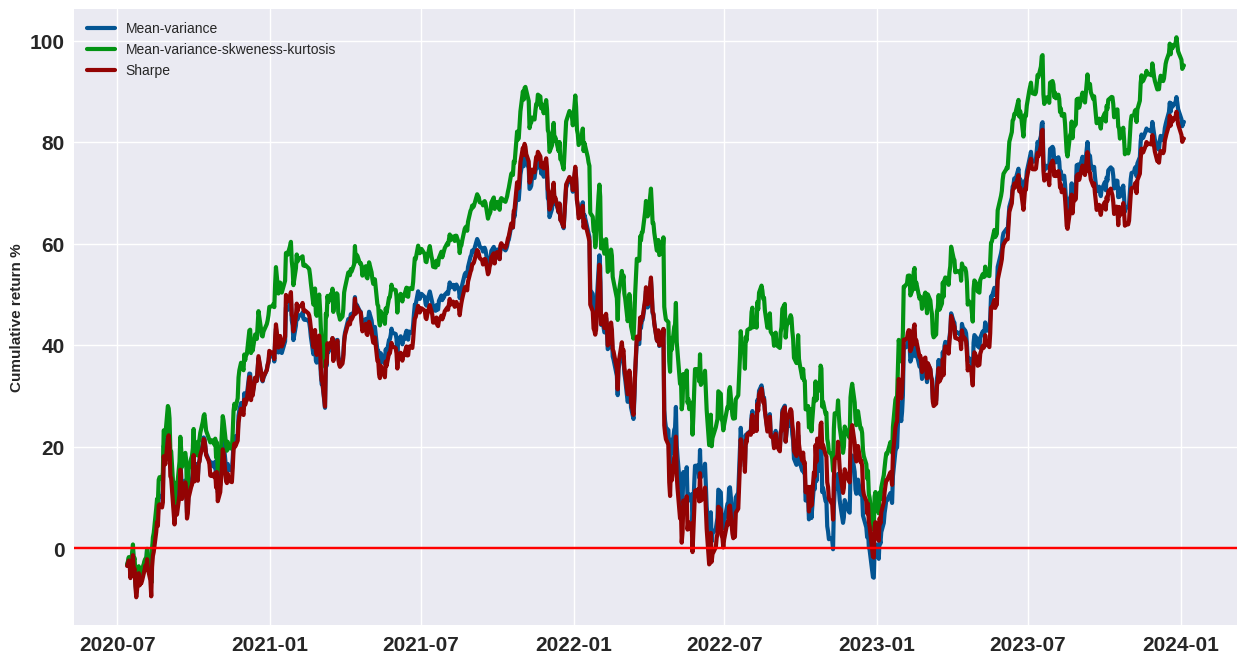

In [13]:
# Compute the cumulative return of the portfolio (CM)
portfolio_return_SR = np.multiply(test_set,np.transpose(X_SR))
portfolio_return_SR = portfolio_return_SR.sum(axis=1)

# Plot the CM
plt.figure(figsize=(15,8))
plt.plot(np.cumsum(portfolio_return_MV)*100, color="#035593", linewidth=3)
plt.plot(np.cumsum(portfolio_return_SK)*100, color="#039313", linewidth=3)
plt.plot(np.cumsum(portfolio_return_SR)*100, color="#930303", linewidth=3)
plt.ylabel("Cumulative return %",fontweight="bold")
plt.axhline(0, color="r")
plt.legend(["Mean-variance", "Mean-variance-skweness-kurtosis", "Sharpe"])
#plt.title("Cumulative return of the best Sharpe potfolio", size=20)
plt.xticks(size=15,fontweight="bold")
plt.yticks(size=15,fontweight="bold")
plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Portfolio: ['META', 'NFLX', 'TSLA']
    -----------------------------------------------------------------------------
    Beta: 1.636 	 Alpha: 2.42 %	     Sharpe: 0.557 	 Sortino: 0.768
    -----------------------------------------------------------------------------
    VaR: 72.96 %	 cVaR: 86.86 % 	     VaR/cVaR: 1.19 	 drawdown: 62.49 %
    -----------------------------------------------------------------------------
    


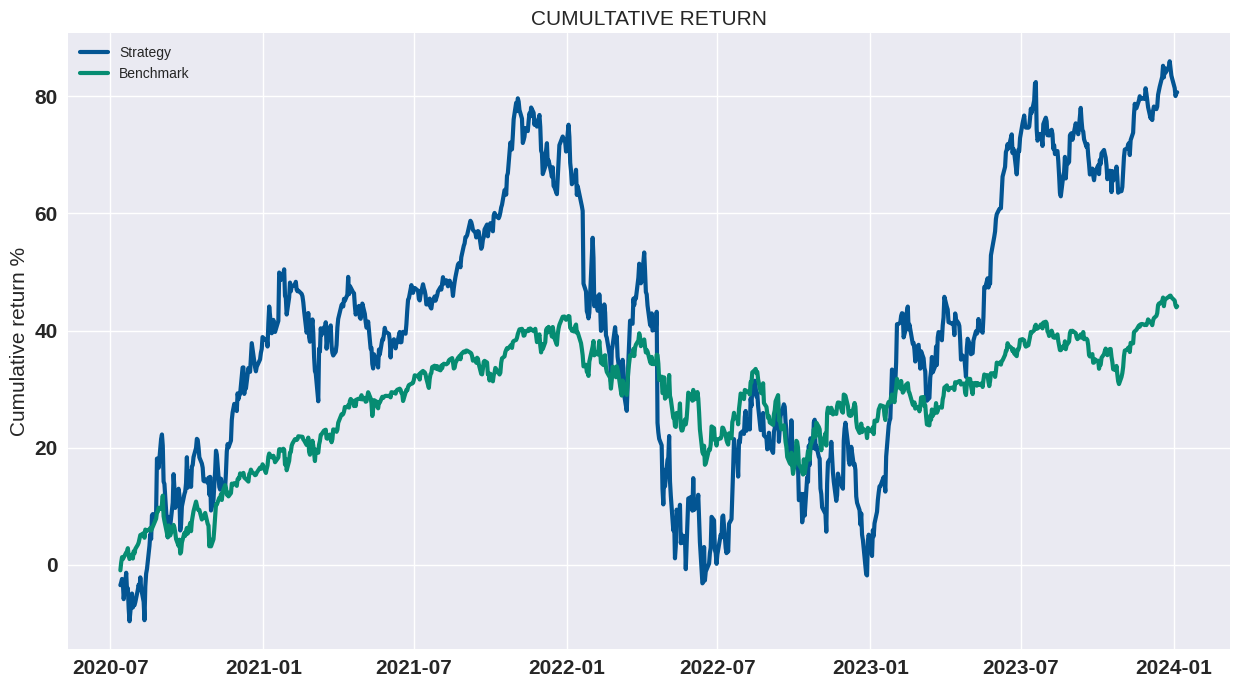

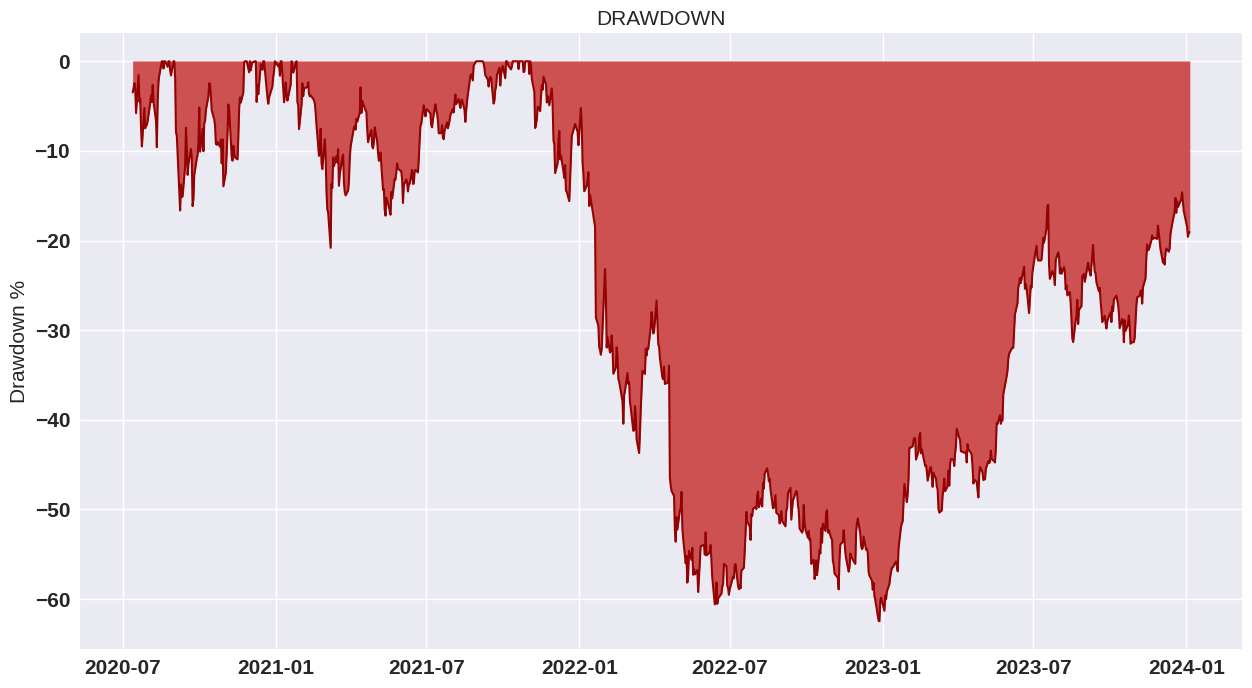

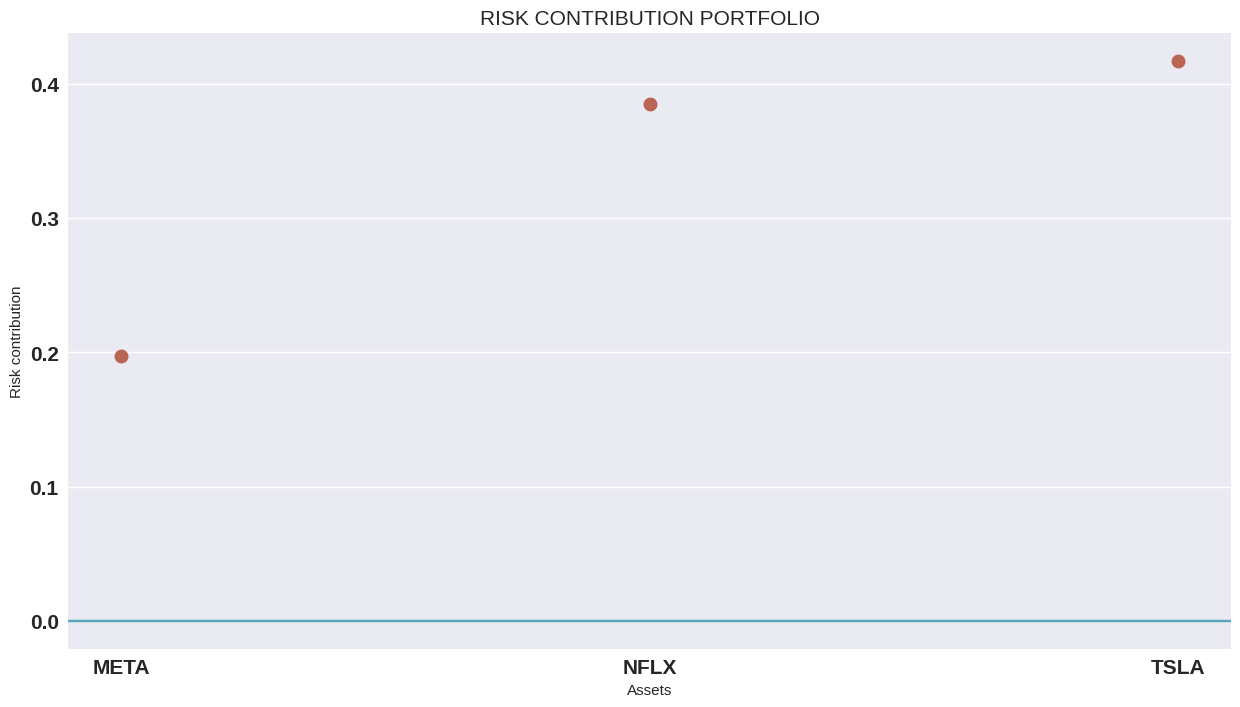

In [45]:
backtest_static_portfolio(X_SR, test_set, CR=True)

<br>
<br>
<br>



# 3.3.2 Sortino ratio criterion

In [14]:
def SOR_criterion(weight, data):
    """
    -----------------------------------------------------------------------------
    | Output: Opposite Sortino ratio to do a m imization                        |
    -----------------------------------------------------------------------------
    | Inputs: -Weight (type ndarray numpy): Wheight for portfolio               |
    |         -data (type dataframe pandas): Returns of stocks                  |
    -----------------------------------------------------------------------------
    """
    # Compute portfolio returns
    portfolio_return = np.multiply(data, np.transpose(weight))
    portfolio_return = portfolio_return.sum(axis=1)

    # Compute mean, volatility of the portfolio
    mean = np.mean(portfolio_return, axis=0)
    std = np.std(portfolio_return[portfolio_return < 0], axis=0)

    # Compute the opposite of the Sharpe ratio
    Sortino = mean / std
    Sortino = -Sortino

    return Sortino

In [47]:
# Find the number of asset
n=data.shape[1]

# Initialization weight value
x0 = np.zeros(n)+1/n

# Optimization constraints problem
cons=({'type':'eq', 'fun': lambda x:sum(abs(x))-1})

# Set the bounds
Bounds= [(0 , 1) for i in range(0,n)]


# Optimization problem solving
res_SOR = minimize(SOR_criterion, x0, method="SLSQP",
                  args=(train_set),bounds=Bounds,
                  constraints=cons,options={'disp': True})

# Result for computations
X_SOR = res_SOR.x

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.14470009555366298
            Iterations: 8
            Function evaluations: 33
            Gradient evaluations: 8


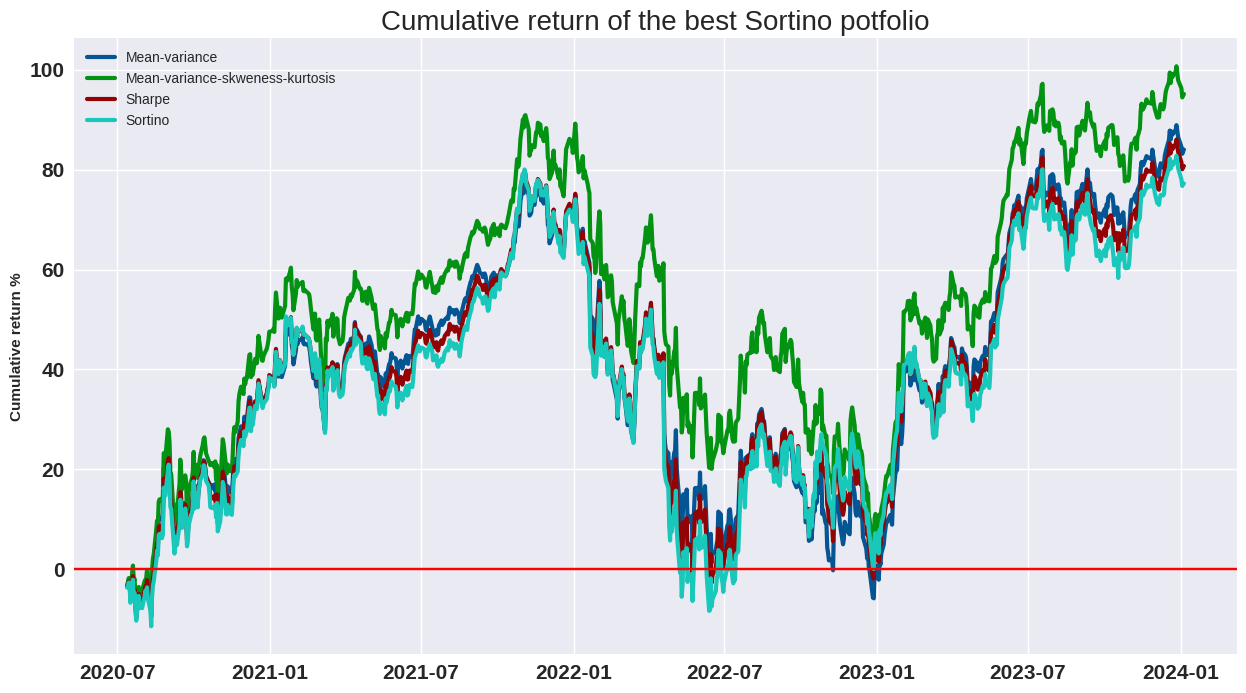

In [16]:
# Compute the cumulative return of the portfolio (CM)
portfolio_return_SOR = np.multiply(test_set,np.transpose(X_SOR))
portfolio_return_SOR = portfolio_return_SOR.sum(axis=1)




# Plot the CM
plt.figure(figsize=(15,8))
plt.plot(np.cumsum(portfolio_return_MV)*100, color="#035593", linewidth=3)
plt.plot(np.cumsum(portfolio_return_SK)*100, color="#039313", linewidth=3)
plt.plot(np.cumsum(portfolio_return_SR)*100, color="#930303", linewidth=3)
plt.plot(np.cumsum(portfolio_return_SOR)*100, color="#18C8BA", linewidth=3)
plt.ylabel("Cumulative return %",fontweight="bold")
plt.axhline(0, color="r")
plt.legend(["Mean-variance", "Mean-variance-skweness-kurtosis", "Sharpe", "Sortino"])
plt.title("Cumulative return of the best Sortino potfolio", size=20)
plt.xticks(size=15,fontweight="bold")
plt.yticks(size=15,fontweight="bold")
plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Portfolio: ['META', 'NFLX', 'TSLA']
    -----------------------------------------------------------------------------
    Beta: 1.618 	 Alpha: 1.66 %	     Sharpe: 0.517 	 Sortino: 0.706
    -----------------------------------------------------------------------------
    VaR: 77.23 %	 cVaR: 92.17 % 	     VaR/cVaR: 1.193 	 drawdown: 63.04 %
    -----------------------------------------------------------------------------
    


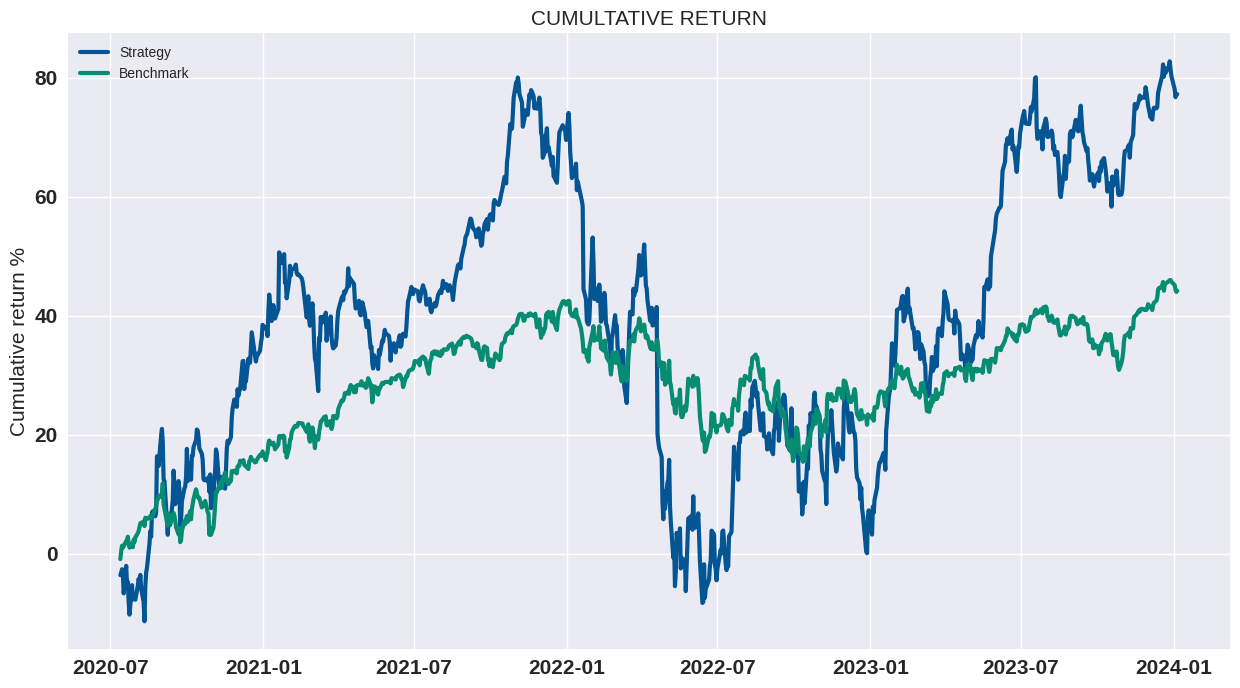

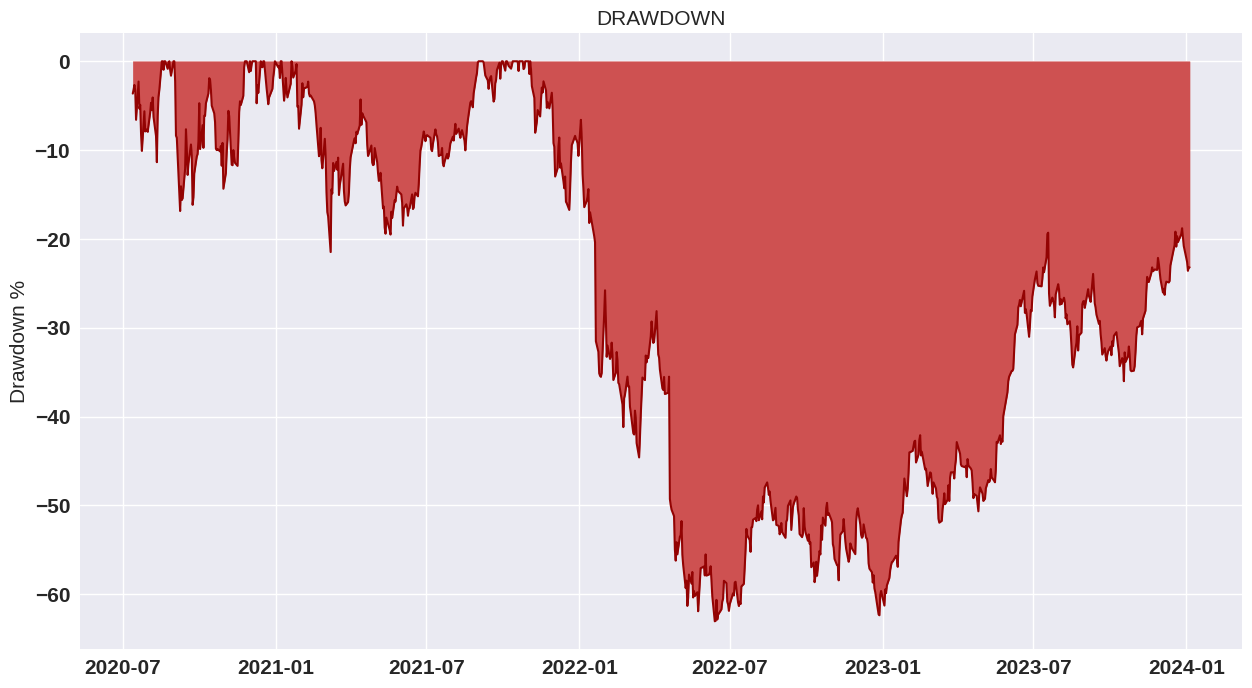

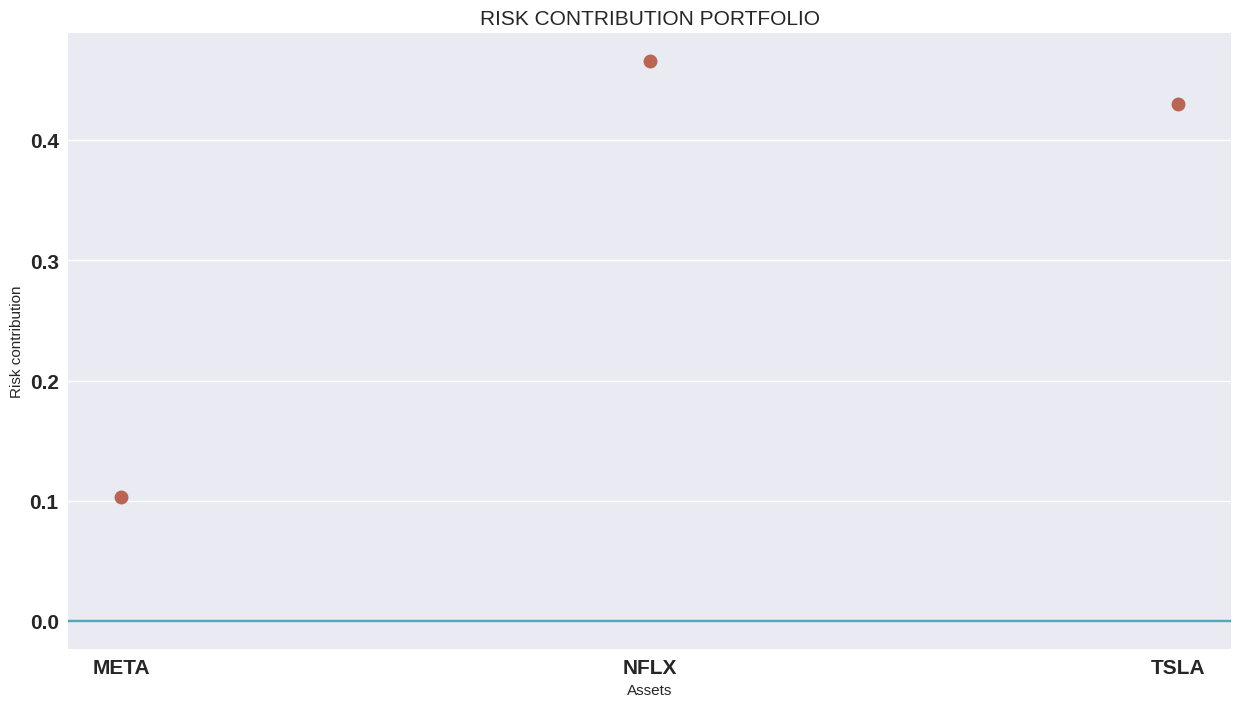

In [46]:
backtest_static_portfolio(X_SOR, test_set, CR=True)